In [20]:
import findspark
findspark.init()

import wptools
import pyspark
import pyspark.sql
from pyspark.sql import *
import os.path
from pyspark.sql.functions import desc

from pyspark.sql import dataframe
from pyspark.sql import functions as F

from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
import seaborn as sns
import re
import pandas as pd

In [2]:
DATA_DIR = '../data/data_processed/'

In [3]:
the_data = spark.read.parquet(DATA_DIR+"union_3_cat.parquet")

In [4]:
# Quantifying null values
# how many rows does the dataframe have?
mili_rows=the_data.count()
from pyspark.sql.functions import isnan, when, count, col

mili_nan = the_data.select([
    count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in the_data.columns
]).toPandas()

mili_percentages_nan = mili_nan*100/mili_rows
mili_percentages_nan.head()

,id,title,categories,article_lenght,views,refs_count,link_count,death,end_date,location
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.331349,12.411266,11.088848


In [5]:
the_data.filter("id = 214659").show()

+------+--------+---------------+--------------+-------+----------+----------+--------------------+---------+--------------------+
|    id|   title|     categories|article_lenght|  views|refs_count|link_count|               death| end_date|            location|
+------+--------+---------------+--------------+-------+----------+----------+--------------------+---------+--------------------+
|214659|Unit 731|civilian attack|         58902|5427192|        78|       249|Over 3,000 from i...|1935–1945|[[Pingfang]], [[H...|
+------+--------+---------------+--------------+-------+----------+----------+--------------------+---------+--------------------+



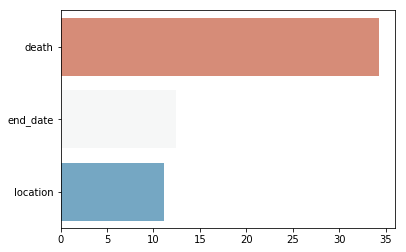

In [6]:
sns.barplot(data=mili_percentages_nan[['death','end_date','location']], palette='RdBu',orient='h');

In [7]:
the_data_pd = the_data.toPandas().set_index('id')
the_data_pd['end_date'].head(30)
# end date need to extract only four digits 

id
50429564                                           1 May 2016
39900222                                          22 May 2013
46935886                                    December 14, 1993
38247068                                                 None
19896366                                      21 October 2008
2234230                                 +1975-03-05T00:00:00Z
4538300                                           27 May 1940
12983993                                    September 3, 1984
10032978                                       March 11, 2007
41583832                    {{start date and age|1941|04|27}}
52461344                                      16 January 1993
14121621                    {{Start date|df|=|yes|2007|11|7}}
40565322                                 16–17 September 2013
32339772                                                 None
54874862                                       12 August 2017
52299027                                       29 August 1943
21465

In [8]:
the_data_pd['end_date'] = the_data_pd['end_date'].astype('str')
the_data_pd.dtypes

title             object
categories        object
article_lenght     int32
views              int64
refs_count         int64
link_count         int64
death             object
end_date          object
location          object
dtype: object

In [14]:
the_data_pd.sample(50).to_csv('../data/sub_samples/to_clean_data.csv')

 several formats:
 
-  20 October 2010
-  September 20, 1874
-  None
-  {Start date|df|=|yes|2007|11|7}}
-  1812–1813
-  +1902-05-03T00:00:00Z 
-  31 July – 5 September 1941
-  October 2013 to November 2013
-  10/11 August 1944
-  18&ndash;21 August 1992
-  November 18, 2016 — ongoing <br />( {{Age in y...
-  Spring, 397 BC
-  4–10 December 1910

Priority:

- ongoing
- None

If they do not contain one of the two, then:

take only the 3/4 digits starting from the end of the string

In [34]:
def find_pattern(my_str: str) -> str:
    # if my_str == 'None', do nothing
    
    ongoing = re.compile(r"ongoing", re.IGNORECASE)
    digits = re.compile(r"\d{3,}")

    if re.search(ongoing, my_str):
        return "ongoing"
    if re.search(digits, my_str):
        # match the last year
        my_str_rev = my_str[::-1]
        # and reverse
        return re.search(digits, my_str_rev).group(0)[::-1]

In [32]:
the_data_pd['end_date_clean'] = the_data_pd['end_date'].apply(find_pattern)

In [33]:
the_data_pd

,title,categories,article_lenght,views,refs_count,link_count,death,end_date,location,end_date_clean
id,,,,,,,,,,
50429564,2016 Samawa bombing,civilian attack,2488,9998,2,26,33+ (+2),1 May 2016,Samawah (Q750679),2016
39900222,Harok family murder,civilian attack,35907,53091,49,52,4,22 May 2013,"Zatloukalova 404/49a, [[Brno]]-Ivanovice, [[Cz...",2013
46935886,1993 Aurora shooting,"civilian attack, criminal",10075,271842,11,52,4,"December 14, 1993","12293 East Iliff Avenue,<br/>[[Aurora, Colorad...",1993
38247068,In Amenas hostage crisis,civilian attack,55589,99062,106,128,"At least 67 (at least 37 foreign hostages, an ...",None,"West of [[In Amenas]], Algeria",None
19896366,2008 Imphal bombing,civilian attack,19719,5617,20,38,17,21 October 2008,Imphal (Q208097),2008
2234230,Savoy Hotel attack,civilian attack,10713,11059,9,45,"8 civilian hostages, 3 Israeli soldiers, 7 [[F...",+1975-03-05T00:00:00Z,Tel Aviv (Q33935),1975
4538300,Le Paradis massacre,civilian attack,28438,218488,32,76,97,27 May 1940,"Le Paradis village, commune of [[Lestrem]], No...",1940
12983993,1984 Montreal bombing,civilian attack,21695,550,24,100,3,"September 3, 1984","[[Montreal]], [[Quebec]], [[Canada]]",1984
10032978,2007 Casablanca bombings,"terrorist attack, civilian attack",4930,11130,6,33,1 (one perpetrator),"March 11, 2007",Casablanca (Q7903),2007


In [35]:
the_data_pd.to_csv("../data/data_processed/CleanDate_3_cat.csv")